In [3]:
# Cellule 1 (RE-CRÉATION) : Extraction, Transformation (Initiales) et Création de df_fact_sales

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Connexion à SQL Server (Vérifiez si le serveur est bien celui-ci)
server = 'LYNDAMAAMERI\\SQLEXPRESS' 
database = 'Northwind' 
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

# Requête SQL pour la Table de Faits (incluant la Date et les clés métier de la table Orders)
sql_query_fact_table = """
SELECT 
    od."OrderID",
    od."ProductID",
    od."UnitPrice",
    od."Quantity",
    od."Discount",
    o."OrderDate",    -- Garder la colonne OrderDate est VITAL
    o."CustomerID",   -- Clé métier pour la dimension Client
    o."EmployeeID",   -- Clé métier pour la dimension Employé
    o."ShipVia"       -- Clé métier pour la dimension Transporteur
FROM 
    "Order Details" od
JOIN 
    Orders o ON od.OrderID = o.OrderID;
"""
try:
    # L'exécution de cette ligne crée la variable 'df_fact_sales'
    df_fact_sales = pd.read_sql(sql_query_fact_table, engine)
    
    # 1. Conversion de la date
    df_fact_sales['OrderDate'] = pd.to_datetime(df_fact_sales['OrderDate'])
    
    # 2. Ajout de la colonne 'CA' (Chiffre d'Affaires)
    df_fact_sales['CA'] = (df_fact_sales['UnitPrice'] * df_fact_sales['Quantity'] * (1 - df_fact_sales['Discount']))
    
    print("✅ Cellule 1 : df_fact_sales extrait avec toutes les clés nécessaires (OrderDate, CustomerID, etc.).")

except Exception as e:
    print(f"❌ ERREUR LORS DE L'EXTRACTION. Vérifiez votre chaîne de connexion : {e}")

✅ Cellule 1 : df_fact_sales extrait avec toutes les clés nécessaires (OrderDate, CustomerID, etc.).


In [4]:
# Cellule 2 : Agrégation et Calcul du KPI Mensuel

# 1. Création de la clé temporelle 'Annee_Mois'
df_fact_sales['Annee_Mois'] = df_fact_sales['OrderDate'].dt.to_period('M').astype(str)

# 2. Agrégation (Groupement par mois et sommation du CA)
# **CETTE LIGNE CRÉE df_monthly_sales**
df_monthly_sales = (
    df_fact_sales
    .groupby('Annee_Mois')['CA']
    .sum()
    .reset_index()
)

# 3. Renommage de la colonne pour le Dashboard
df_monthly_sales.rename(columns={'CA': 'SalesAmount'}, inplace=True)

print("✅ df_monthly_sales créé et prêt pour la visualisation.")

✅ df_monthly_sales créé et prêt pour la visualisation.


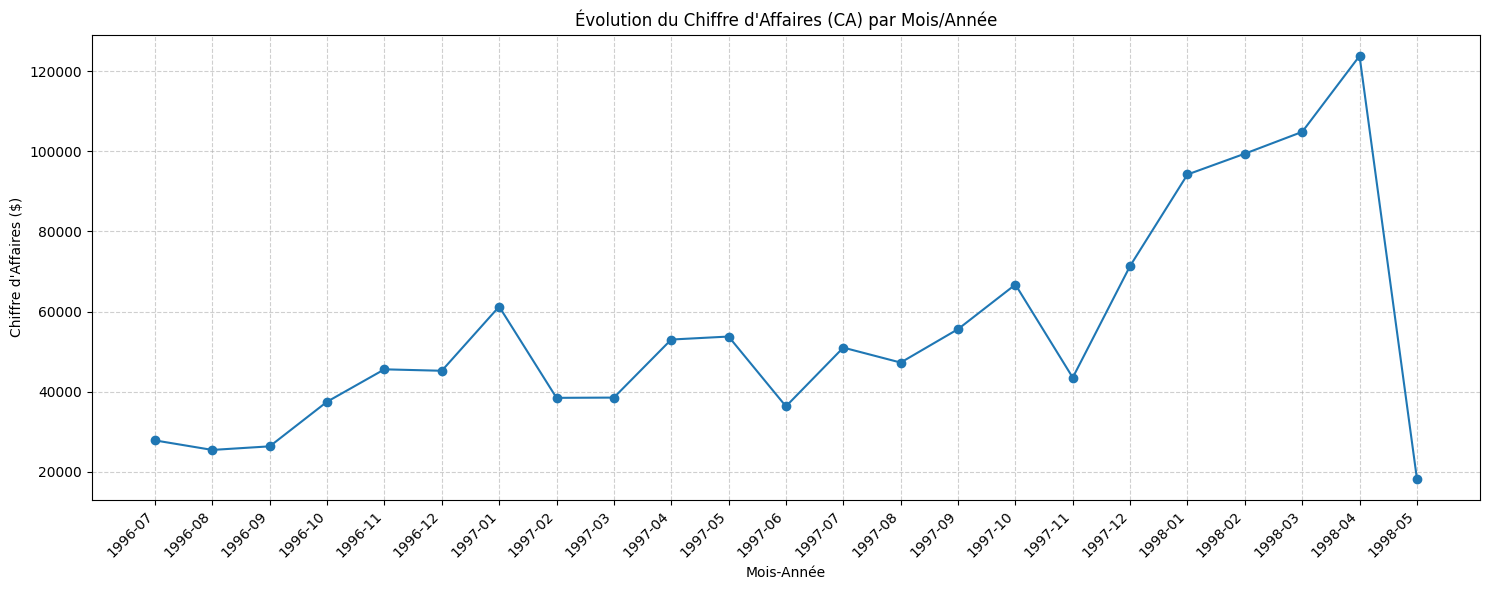


🎉 Tableau de bord (Graphique d'évolution) généré avec succès.


In [5]:
# Cellule 3 : Visualisation du Chiffre d'Affaires Mensuel

plt.figure(figsize=(15, 6))
plt.plot(
    df_monthly_sales['Annee_Mois'],
    df_monthly_sales['SalesAmount'],
    marker='o',
    linestyle='-',
    color='#1f77b4'
)

# Configuration de l'affichage
plt.title("Évolution du Chiffre d'Affaires (CA) par Mois/Année")
plt.xlabel('Mois-Année')
plt.ylabel("Chiffre d'Affaires ($)")
plt.xticks(rotation=45, ha='right') 
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n🎉 Tableau de bord (Graphique d'évolution) généré avec succès.")

In [6]:
# Cellule 4 : Création des Tables de Dimensions Statiques

# AJOUTER L'IMPORT DE PANDAS
import pandas as pd

# CODE MODIFIÉ DANS LA CELLULE 4

# 1. Dimension Client (df_dim_customer)
df_dim_customer = pd.read_sql('SELECT * FROM Customers', engine)
df_dim_customer.columns = df_dim_customer.columns.str.lower() # Mettre toutes les colonnes en minuscules

# AJOUT CRITIQUE POUR LA COLONNE PAYS (AU CAS OÙ LA MISE EN MINUSCULE A ÉCHOUÉ)
# Nous renommons la colonne Pays en 'country' si elle était initialement 'Country' dans la BDD.
if 'country' not in df_dim_customer.columns:
    if 'Country' in df_dim_customer.columns:
        df_dim_customer.rename(columns={'Country': 'country'}, inplace=True)

df_dim_customer.rename(columns={'customerid': 'customersk'}, inplace=True) # Renommer la clé métier en SK


# CODE CRITIQUE DANS LA CELLULE 4

# Cellule 4 : Création des Tables de Dimensions Statiques

# ... (Début de la cellule) ...

# 2. Dimension Employé (df_dim_employee)
df_dim_employee = pd.read_sql('SELECT * FROM Employees', engine)
df_dim_employee.columns = df_dim_employee.columns.str.lower() # Mettre toutes les colonnes en minuscules
df_dim_employee.rename(columns={'employeeid': 'employeesk'}, inplace=True) # Renommer la clé métier en SK
# Nettoyage et concaténation pour un nom complet lisible
df_dim_employee['fullname'] = df_dim_employee['firstname'] + ' ' + df_dim_employee['lastname']

# CETTE SÉLECTION FINALE DOIT INCLURE ABSOLUMENT 'employeesk' ET 'fullname'
df_dim_employee = df_dim_employee[['employeesk', 'fullname', 'title', 'city', 'country']] 

print("✅ Dimension Employé (df_dim_employee) créée.")

# ... (Le reste de la cellule 4)

# --- 3. Dimension Transporteur (df_dim_shipper) ---
df_dim_shipper = pd.read_sql('SELECT * FROM Shippers', engine)
df_dim_shipper.columns = df_dim_shipper.columns.str.lower() # Mettre toutes les colonnes en minuscules
df_dim_shipper.rename(columns={'shipperid': 'shippersk'}, inplace=True) # Renommer la clé métier en SK
# Nettoyage : Sélectionner uniquement les colonnes BI pertinentes
df_dim_shipper = df_dim_shipper[['shippersk', 'companyname']]
print("✅ Dimension Transporteur (df_dim_shipper) créée et nettoyée.")
# Diagnostic de la Cellule 4
print("Colonnes finales de df_dim_customer:")
print(df_dim_customer.columns)
# NOTE: La création de df_monthly_sales a été retirée de cette cellule.

✅ Dimension Employé (df_dim_employee) créée.
✅ Dimension Transporteur (df_dim_shipper) créée et nettoyée.
Colonnes finales de df_dim_customer:
Index(['customersk', 'companyname', 'contactname', 'contacttitle', 'address',
       'city', 'region', 'postalcode', 'country', 'phone', 'fax'],
      dtype='object')


In [7]:
# CELLULE DE DIAGNOSTIC - À EXÉCUTER APRÈS LA CELLULE 5
print("Colonnes actuelles de df_fact_sales après la Cellule 5 :")
print(df_fact_sales.columns.tolist())

Colonnes actuelles de df_fact_sales après la Cellule 5 :
['OrderID', 'ProductID', 'UnitPrice', 'Quantity', 'Discount', 'OrderDate', 'CustomerID', 'EmployeeID', 'ShipVia', 'CA', 'Annee_Mois']


In [8]:
# --- Cellule 5 : Jointure et Finalisation ---

# 1. Mise en minuscules de toutes les tables pour éviter les erreurs de frappe
df_fact_sales.columns = df_fact_sales.columns.str.lower().str.strip()
df_dim_customer.columns = df_dim_customer.columns.str.lower().str.strip()
df_dim_employee.columns = df_dim_employee.columns.str.lower().str.strip()

# 2. Vérification : Si 'fullname' n'est pas dans la dimension employé, on le crée
if 'fullname' not in df_dim_employee.columns:
    # On cherche 'firstname' et 'lastname'
    df_dim_employee['fullname'] = df_dim_employee['firstname'] + " " + df_dim_employee['lastname']

# 3. JOINTURES
# On fusionne pour ramener 'companyname' et 'country' des clients
df_fact_sales = pd.merge(
    df_fact_sales, 
    df_dim_customer[['customersk', 'companyname', 'country']], 
    left_on='customerid', right_on='customersk', 
    how='left'
)

# On fusionne pour ramener 'fullname' des employés
df_fact_sales = pd.merge(
    df_fact_sales, 
    df_dim_employee[['employeesk', 'fullname']], 
    left_on='employeeid', right_on='employeesk', 
    how='left'
)

# 4. Vérification finale
if 'fullname' in df_fact_sales.columns:
    print("✅ SUCCÈS : La colonne 'fullname' est maintenant dans df_fact_sales.")
    print(f"Colonnes disponibles : {df_fact_sales.columns.tolist()}")
else:
    print("❌ ERREUR : La jointure a échoué. Vérifiez que 'employeeid' existe dans les deux tables.")

✅ SUCCÈS : La colonne 'fullname' est maintenant dans df_fact_sales.
Colonnes disponibles : ['orderid', 'productid', 'unitprice', 'quantity', 'discount', 'orderdate', 'customerid', 'employeeid', 'shipvia', 'ca', 'annee_mois', 'customersk', 'companyname', 'country', 'employeesk', 'fullname']


In [9]:
import plotly.express as px
import plotly.io as pio

# On force l'ouverture dans le navigateur pour éviter les erreurs de rendu VS Code
pio.renderers.default = "browser"

# 1. Top 5 Employés
df_top_emp = df_fact_sales.groupby('fullname')['ca'].sum().nlargest(5).reset_index()

# 2. Top 5 Clients
df_top_cust = df_fact_sales.groupby('companyname')['ca'].sum().nlargest(5).reset_index()

# --- GRAPHIQUES ---

fig_emp = px.bar(df_top_emp, x='fullname', y='ca', color='ca',
                 title="Top 5 Employés par CA", color_continuous_scale='GnBu')

fig_cust = px.bar(df_top_cust, x='companyname', y='ca', color='ca',
                  title="Top 5 Clients par CA", color_continuous_scale='Viridis')

fig_emp.show()
fig_cust.show()

# Export pour le Dashboard Dash
df_fact_sales.to_csv("../df_final_data.csv", index=False)